# Aula 7 - Machine Learning

# Demo 15 - Técnicas de Ensembles


1. [Introdução](#1)
    
1. [**Técnicas de Ensemble**](#2)
    
    2.1 [**Max Voting / Voting Classifier**](#21)
    
    2.2 [**Averaging**](#22)
    
    2.3 [**Weighted Averaging**](#23)
    
    2.4 [**Stacking**](#24)
    
    2.5 [**Blending**](#25)
    
    2.6 [**Bagging**](#26)
    
    2.7 [**Boosting**](#27)

1. [Referências](#3)  

1. [Conclusão](#4)  

    
# 1. Introdução <a id="1"></a> <br>
    
**Modelos de Ensemble** têm por. ideia principal melhorar os resultados advindos de algoritmos em ML ao combinar vários modelos de modo a melhor a performance preditiva quando comparado a um modelo único.  

![](https://i.imgur.com/L2Jaqm8.png)
    
# 2. Ensemble Techniques <a id="2"></a> <br>

## 2.1 Max Voting / Voting Classifier <a id="2.1"></a> <br>

Vamos usar o dataset IRIS para demonstrar um voting classifier.

In [1]:
# imports
from sklearn.ensemble import VotingClassifier ,BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from numpy import mean,std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold,train_test_split
from sklearn.linear_model import LogisticRegression,RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from matplotlib import pyplot
from sklearn.datasets import load_wine,load_iris
from matplotlib.pyplot import figure
figure(num=2, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
import xgboost as xgb
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.linear_model import LinearRegression,BayesianRidge,ElasticNet,Lasso,SGDRegressor,Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,RobustScaler,StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA,KernelPCA
from sklearn.ensemble import ExtraTreesRegressor,GradientBoostingRegressor,RandomForestRegressor,VotingClassifier
from sklearn.model_selection import cross_val_score,KFold,GridSearchCV,RandomizedSearchCV,StratifiedKFold,train_test_split
from sklearn.base import BaseEstimator,clone,TransformerMixin,RegressorMixin
from sklearn.svm import LinearSVR,SVR
#import xgboost
from xgboost import XGBRegressor
#Import pandas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import skew
from scipy.stats.stats import pearsonr
%matplotlib inline
seed = 1075
np.random.seed(seed)

<Figure size 1280x960 with 0 Axes>

In [2]:
# carregando o iris dataset
iris = load_iris()
X = iris.data[:, :4]
Y = iris.target

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.20,random_state = 42)

In [4]:
# Ensemble de modelos
estimator = []
estimator.append(('LR',LogisticRegression(solver ='lbfgs',multi_class ='multinomial',max_iter = 200)))
estimator.append(('SVC', SVC(gamma ='auto', probability = True)))
estimator.append(('DTC', DecisionTreeClassifier()))

**Voting Classifier** suporta dois tipos de "voto"

**Hard Voting:**
![](https://image.slidesharecdn.com/7-180514114334/95/ensemble-learning-and-random-forests-12-638.jpg?cb=1527755412)

In [5]:
# Voting Classifier com hard voting
hard_voting = VotingClassifier(estimators = estimator, voting ='hard')
hard_voting.fit(X_train, y_train)
y_pred = hard_voting.predict(X_test)

In [6]:
# accuracy_score metric de modo a predizer Accuracy
score = accuracy_score(y_test, y_pred)
print("Hard Voting Score % d" % score)

Hard Voting Score  1


**Soft Voting:**

In [7]:
# Voting Classifier com soft voting
soft_voting = VotingClassifier(estimators = estimator, voting ='soft')
soft_voting.fit(X_train, y_train)
y_pred = soft_voting.predict(X_test)

In [8]:
# Usando accuracy_score
score = accuracy_score(y_test, y_pred)
print("Soft Voting Score % d" % score)

Soft Voting Score  1


## 2.2 Averaging <a id="2.2"></a> <br>


In [9]:
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame

In [10]:
# gerando um dataset de classificacao 2d
X, y = make_blobs(n_samples=500, centers=3, n_features=2, cluster_std=2, random_state=2)

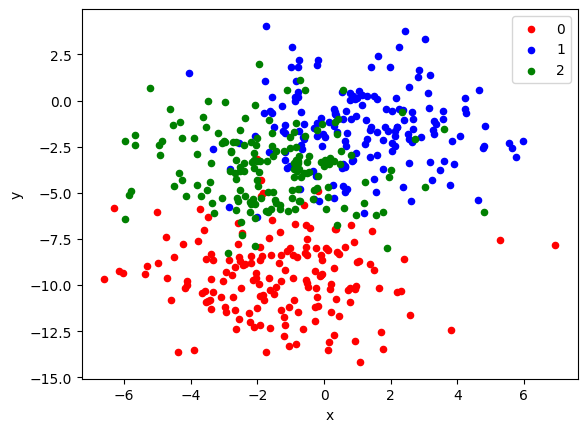

In [11]:
# scatter plot
df = DataFrame(dict(x=X[:,0], y=X[:,1], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

## 2.3 Weighted Averaging <a id="2.3"></a> <br>

![](https://www.analyticsvidhya.com/wp-content/uploads/2015/08/Screen-Shot-2015-08-22-at-6.40.37-pm.png)

In [12]:
train_dataset = "https://raw.githubusercontent.com/ahirtonlopes/Mastering-Machine-Learning/main/Projetos/train.csv"
test_dataset = "https://raw.githubusercontent.com/ahirtonlopes/Mastering-Machine-Learning/main/Projetos/test.csv"

In [13]:
train = pd.read_csv(train_dataset,na_values = '#NAME?')
test = pd.read_csv(test_dataset,na_values = '#NAME?')

Baseado na distribuição dos dados, vamos remover alguns outliers

In [14]:
train.drop(train[(train['GrLivArea'] >4000) & (train['SalePrice']<300000)].index,inplace = True)

In [15]:
full = pd.concat([train,test],ignore_index=True)
full.drop('Id',axis = 1,inplace = True)
full.shape

(2917, 80)

Tratamento de valores faltantes

In [16]:
missing_values = full.isnull().sum()
missing_values[missing_values>0].sort_values(ascending = False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
LotFrontage      486
GarageCond       159
GarageYrBlt      159
GarageFinish     159
GarageQual       159
GarageType       157
BsmtExposure      82
BsmtCond          82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Functional         2
BsmtHalfBath       2
BsmtFullBath       2
Utilities          2
KitchenQual        1
TotalBsmtSF        1
BsmtUnfSF          1
GarageCars         1
GarageArea         1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
Electrical         1
dtype: int64

In [17]:
full.groupby(['Neighborhood'])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                    mean median count
Neighborhood                         
Blmngtn        46.900000   43.0    20
Blueste        27.300000   24.0    10
BrDale         21.500000   21.0    30
BrkSide        55.789474   51.0    95
ClearCr        88.150000   80.5    20
CollgCr        71.336364   70.0   220
Crawfor        69.951807   70.0    83
Edwards        65.153409   64.5   176
Gilbert        74.207207   64.0   111
IDOTRR         62.241379   60.0    87
MeadowV        25.606061   21.0    33
Mitchel        75.144444   74.0    90
NAmes          75.210667   73.0   375
NPkVill        28.142857   24.0    21
NWAmes         81.517647   80.0    85
NoRidge        91.629630   89.0    54
NridgHt        84.184049   92.0   163
OldTown        61.777293   60.0   229
SWISU          59.068182   60.0    44
Sawyer         74.551020   72.0    98
SawyerW        70.669811   67.0   106
Somerst        64.549383   72.5   162
StoneBr        62.173913   60.0    46
Timber         81.157895   82.0    57
Veenker        72.000000   80.0    16

In [18]:
full['LotAreaCut'] = pd.qcut(full.LotArea,10)

full.groupby([full['LotAreaCut']])[['LotFrontage']].agg(['mean','median','count'])

LotFrontage             
                           mean median count
LotAreaCut                                  
(1299.999, 4921.8]    35.741036   34.0   251
(4921.8, 7007.2]      55.460674   52.0   267
(7007.2, 7949.0]      62.959839   62.0   249
(7949.0, 8740.4]      67.113725   65.0   255
(8740.4, 9452.0]      69.959184   70.0   245
(9452.0, 10148.8]     73.988235   75.0   255
(10148.8, 11000.0]    73.636364   75.0   253
(11000.0, 12196.8]    83.371681   82.0   226
(12196.8, 14285.8]    84.973684   85.0   228
(14285.8, 215245.0]   92.846535   90.0   202

In [19]:
full['LotFrontage']= full.groupby(['LotAreaCut','Neighborhood'])['LotFrontage'].transform(lambda x : x.fillna(x.median()))
full['LotFrontage']= full.groupby(['LotAreaCut'])['LotFrontage'].transform(lambda x : x.fillna(x.median()))

In [20]:
missing_values = full.isnull().sum()

missing_values[missing_values>0].sort_values(ascending = False)

PoolQC          2908
MiscFeature     2812
Alley           2719
Fence           2346
SalePrice       1459
FireplaceQu     1420
GarageCond       159
GarageQual       159
GarageFinish     159
GarageYrBlt      159
GarageType       157
BsmtCond          82
BsmtExposure      82
BsmtQual          81
BsmtFinType2      80
BsmtFinType1      79
MasVnrType        24
MasVnrArea        23
MSZoning           4
Functional         2
BsmtHalfBath       2
Utilities          2
BsmtFullBath       2
KitchenQual        1
Electrical         1
TotalBsmtSF        1
BsmtUnfSF          1
GarageCars         1
GarageArea         1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

In [21]:
columns = ["MasVnrArea", "BsmtUnfSF", "TotalBsmtSF", "GarageCars", "BsmtFinSF2", "BsmtFinSF1", "GarageArea"]
for col in columns:full[col].fillna(0,inplace= True)

In [22]:
columns1 = ["PoolQC" , "MiscFeature", "Alley", "Fence", "FireplaceQu", "GarageQual", "GarageCond", "GarageFinish",
"GarageYrBlt", "GarageType", "BsmtExposure", "BsmtCond", "BsmtQual", "BsmtFinType2", "BsmtFinType1", "MasVnrType"]
for col1 in columns1:full[col1].fillna('None',inplace = True)

In [23]:
columns2 = ["MSZoning", "BsmtFullBath", "BsmtHalfBath", "Utilities", "Functional",
            "Electrical", "KitchenQual", "SaleType","Exterior1st", "Exterior2nd"]

for col2 in columns2:
    full[col2].fillna(full[col2].mode()[0],inplace = True)

In [24]:
full.isnull().sum()[full.isnull().sum()>0]

SalePrice    1459
dtype: int64

In [25]:
numeric_features = full.select_dtypes(include=[np.number])
numeric_features.columns

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [26]:
Numstr = ["MSSubClass","BsmtFullBath","BsmtHalfBath","HalfBath","BedroomAbvGr","KitchenAbvGr","MoSold",
          "YrSold","YearBuilt","YearRemodAdd","LowQualFinSF","GarageYrBlt"]

for i in Numstr:
    full[i]=full[i].astype(str)

In [27]:
full.groupby(['MSSubClass'])[['SalePrice']].agg(['mean','median','count'])

SalePrice                
                     mean    median count
MSSubClass                               
120         200779.080460  192000.0    87
150                   NaN       NaN     0
160         138647.380952  146000.0    63
180         102300.000000   88500.0    10
190         129613.333333  128250.0    30
20          185224.811567  159250.0   536
30           95829.724638   99900.0    69
40          156125.000000  142500.0     4
45          108591.666667  107500.0    12
50          143302.972222  132000.0   144
60          240403.542088  216000.0   297
70          166772.416667  156000.0    60
75          192437.500000  163500.0    16
80          169736.551724  166500.0    58
85          147810.000000  140750.0    20
90          133541.076923  135980.0    52

In [28]:
def map_values():
    full["oMSSubClass"] = full.MSSubClass.map({'180':1,
                                        '30':2, '45':2,
                                        '190':3, '50':3, '90':3,
                                        '85':4, '40':4, '160':4,
                                        '70':5, '20':5, '75':5, '80':5, '150':5,
                                        '120': 6, '60':6})

    full["oMSZoning"] = full.MSZoning.map({'C (all)':1, 'RH':2, 'RM':2, 'RL':3, 'FV':4})
    full["oNeighborhood"] = full.Neighborhood.map({'MeadowV':1,
                                               'IDOTRR':2, 'BrDale':2,
                                               'OldTown':3, 'Edwards':3, 'BrkSide':3,
                                               'Sawyer':4, 'Blueste':4, 'SWISU':4, 'NAmes':4,
                                               'NPkVill':5, 'Mitchel':5,
                                               'SawyerW':6, 'Gilbert':6, 'NWAmes':6,
                                               'Blmngtn':7, 'CollgCr':7, 'ClearCr':7, 'Crawfor':7,
                                               'Veenker':8, 'Somerst':8, 'Timber':8,
                                               'StoneBr':9,
                                               'NoRidge':10, 'NridgHt':10})

    full["oCondition1"] = full.Condition1.map({'Artery':1,
                                           'Feedr':2, 'RRAe':2,
                                           'Norm':3, 'RRAn':3,
                                           'PosN':4, 'RRNe':4,
                                           'PosA':5 ,'RRNn':5})

    full["oBldgType"] = full.BldgType.map({'2fmCon':1, 'Duplex':1, 'Twnhs':1, '1Fam':2, 'TwnhsE':2})

    full["oHouseStyle"] = full.HouseStyle.map({'1.5Unf':1,
                                           '1.5Fin':2, '2.5Unf':2, 'SFoyer':2,
                                           '1Story':3, 'SLvl':3,
                                           '2Story':4, '2.5Fin':4})

    full["oExterior1st"] = full.Exterior1st.map({'BrkComm':1,
                                             'AsphShn':2, 'CBlock':2, 'AsbShng':2,
                                             'WdShing':3, 'Wd Sdng':3, 'MetalSd':3, 'Stucco':3, 'HdBoard':3,
                                             'BrkFace':4, 'Plywood':4,
                                             'VinylSd':5,
                                             'CemntBd':6,
                                             'Stone':7, 'ImStucc':7})

    full["oMasVnrType"] = full.MasVnrType.map({'BrkCmn':1, 'None':1, 'BrkFace':2, 'Stone':3})

    full["oExterQual"] = full.ExterQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})

    full["oFoundation"] = full.Foundation.map({'Slab':1,
                                           'BrkTil':2, 'CBlock':2, 'Stone':2,
                                           'Wood':3, 'PConc':4})

    full["oBsmtQual"] = full.BsmtQual.map({'Fa':2, 'None':1, 'TA':3, 'Gd':4, 'Ex':5})

    full["oBsmtExposure"] = full.BsmtExposure.map({'None':1, 'No':2, 'Av':3, 'Mn':3, 'Gd':4})

    full["oHeating"] = full.Heating.map({'Floor':1, 'Grav':1, 'Wall':2, 'OthW':3, 'GasW':4, 'GasA':5})

    full["oHeatingQC"] = full.HeatingQC.map({'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

    full["oKitchenQual"] = full.KitchenQual.map({'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})

    full["oFunctional"] = full.Functional.map({'Maj2':1, 'Maj1':2, 'Min1':2, 'Min2':2, 'Mod':2, 'Sev':2, 'Typ':3})

    full["oFireplaceQu"] = full.FireplaceQu.map({'None':1, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5})

    full["oGarageType"] = full.GarageType.map({'CarPort':1, 'None':1,
                                           'Detchd':2,
                                           '2Types':3, 'Basment':3,
                                           'Attchd':4, 'BuiltIn':5})

    full["oGarageFinish"] = full.GarageFinish.map({'None':1, 'Unf':2, 'RFn':3, 'Fin':4})

    full["oPavedDrive"] = full.PavedDrive.map({'N':1, 'P':2, 'Y':3})

    full["oSaleType"] = full.SaleType.map({'COD':1, 'ConLD':1, 'ConLI':1, 'ConLw':1, 'Oth':1, 'WD':1,
                                       'CWD':2, 'Con':3, 'New':3})

    full["oSaleCondition"] = full.SaleCondition.map({'AdjLand':1, 'Abnorml':2, 'Alloca':2, 'Family':2, 'Normal':3, 'Partial':4})




    return "Done!"


In [29]:
map_values()

'Done!'

In [30]:
# dropando duas colunas desnecessárias
full.drop("LotAreaCut",axis=1,inplace=True)

full.drop(['SalePrice'],axis=1,inplace=True)

In [31]:
full[['YearBuilt','YearRemodAdd','GarageYrBlt']].head()

,YearBuilt,YearRemodAdd,GarageYrBlt
0,2003,2003,2003.0
1,1976,1976,1976.0
2,2001,2002,2001.0
3,1915,1970,1998.0
4,2000,2000,2000.0


In [32]:
class labenc(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        label = LabelEncoder()
        X['YearBuilt']=label.fit_transform(X['YearBuilt'])
        X['YearRemodAdd']=label.fit_transform(X['YearRemodAdd'])
        X['GarageYrBlt']=label.fit_transform(X['GarageYrBlt'])
        return X


In [33]:
class skewness(BaseEstimator,TransformerMixin):
    def __init__(self,skew=0.5):
        self.skew = skew
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X_numeric=X.select_dtypes(exclude=["object"])
        skewness = X_numeric.apply(lambda x: skew(x))
        skewness_features = skewness[abs(skewness) >= self.skew].index
        X[skewness_features] = np.log1p(X[skewness_features])
        return X

In [34]:
class dummies(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X = pd.get_dummies(X)
        return X

In [35]:
pipeline = Pipeline([('labenc',labenc()),('skewness',skewness(skew =1)),('dummies',dummies())])

In [36]:
full_copy = full.copy()
data_pipeline = pipeline.fit_transform(full_copy)

In [37]:
robust_scaler = RobustScaler()

In [38]:
n_train = train.shape[0]
n_train

1458

In [39]:
X= data_pipeline[:n_train]
y = train.SalePrice
test_X = data_pipeline[n_train:]
X.shape,y.shape,test_X.shape

((1458, 405), (1458,), (1459, 405))

In [40]:
X_scaled = robust_scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = robust_scaler.transform(test_X)

In [41]:
X_scaled.shape,y_log.shape,test_X.shape

((1458, 405), (1458,), (1459, 405))

In [42]:
class add_feature(BaseEstimator, TransformerMixin):
    def __init__(self,additional=1):
        self.additional = additional

    def fit(self,X,y=None):
        return self

    def transform(self,X):
        if self.additional==1:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]

        else:
            X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]
            X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]

            X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
            X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]
            X["+_oMSZoning_TotalHouse"] = X["oMSZoning"] * X["TotalHouse"]
            X["+_oMSZoning_OverallQual"] = X["oMSZoning"] + X["OverallQual"]
            X["+_oMSZoning_YearBuilt"] = X["oMSZoning"] + X["YearBuilt"]
            X["+_oNeighborhood_TotalHouse"] = X["oNeighborhood"] * X["TotalHouse"]
            X["+_oNeighborhood_OverallQual"] = X["oNeighborhood"] + X["OverallQual"]
            X["+_oNeighborhood_YearBuilt"] = X["oNeighborhood"] + X["YearBuilt"]
            X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]

            X["-_oFunctional_TotalHouse"] = X["oFunctional"] * X["TotalHouse"]
            X["-_oFunctional_OverallQual"] = X["oFunctional"] + X["OverallQual"]
            X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
            X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]
            X["-_oCondition1_TotalHouse"] = X["oCondition1"] * X["TotalHouse"]
            X["-_oCondition1_OverallQual"] = X["oCondition1"] + X["OverallQual"]


            X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
            X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
            X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
            X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]


            return X

In [43]:
pipeline = Pipeline([('labenc',labenc()),('add_feature', add_feature(additional=2)),
                     ('skewness',skewness(skew =1)),('dummies',dummies())])

full_pipe = pipeline.fit_transform(full)
full_pipe.shape

(2917, 426)

In [44]:
n_train=train.shape[0]
X = full_pipe[:n_train]
test_X = full_pipe[n_train:]
y= train.SalePrice

X_scaled = robust_scaler.fit(X).transform(X)
y_log = np.log(train.SalePrice)
test_X_scaled = robust_scaler.transform(test_X)

In [45]:
print(X_scaled.shape)

(1458, 426)


In [46]:
# Root Mean Square Error
def rmse_cv(model,X,y):
    rmse = np.sqrt(-cross_val_score(model,X,y,scoring="neg_mean_squared_error",cv=5))
    return rmse

### Modelos incluem alguns clássicos vistos em sala como LinearRegression e outros como Ridge, Lasso e Random Forest, que valem a pena conhecer.

   - LinearRegression
   - Ridge
   - Lasso
   - Random Forest

In [47]:
models = [LinearRegression(),
             Ridge(),
             Lasso(alpha=0.01,max_iter=10000),
             RandomForestRegressor(),
             GradientBoostingRegressor(),
             SVR(),
             LinearSVR(),
             ElasticNet(alpha = 0.001,max_iter=10000),
             SGDRegressor(max_iter=1000, tol = 1e-3),
             BayesianRidge(),
             KernelRidge(alpha=0.6,kernel='polynomial',degree = 2,coef0=2.5),
             ExtraTreesRegressor(),
             XGBRegressor()
             ]

In [48]:
names = ['LR','Ridge','Lasso','RF','GBR','SVR','LSVR','ENet','SGDR','BayRidge','Kernel','XTreeR','XGBR']

In [49]:
for model,name in zip(models,names):
    score = rmse_cv(model,X_scaled,y_log)
    print("{}: {:.6f}, {:4f}".format(name,score.mean(),score.std()))

LR: 2362226781.982901, 4250360616.544543
Ridge: 0.117596, 0.009054
Lasso: 0.120932, 0.005813
RF: 0.131029, 0.007191
GBR: 0.121335, 0.004460
SVR: 0.131747, 0.010868
LSVR: 0.126264, 0.007887
ENet: 0.108729, 0.005422
SGDR: 0.298565, 0.008996
BayRidge: 0.110576, 0.005997
Kernel: 0.109421, 0.005545
XTreeR: 0.125309, 0.007176
XGBR: 0.132300, 0.004476


In [50]:
class AverageWeight(BaseEstimator, RegressorMixin):
    def __init__(self,model,weight):
        self.model = model
        self.weight = weight

    def fit(self,X,y):
        self.models_ = [clone(x) for x in self.model]
        for model in self.models_:
            model.fit(X,y)
        return self

    def predict(self,X):
        w = list()
        pred = np.array([model.predict(X) for model in self.models_])

        for data in range(pred.shape[1]):
            single = [pred[model,data]*weight for model,weight in zip(range(pred.shape[0]),self.weight)]
            w.append(np.sum(single))
        return w

In [51]:
lasso = Lasso(alpha= 0.0005, max_iter= 10000)
ridge = Ridge(alpha=45, max_iter= 10000)
svr = SVR(C = 0.2, epsilon= 0.025, gamma = 0.0004, kernel = 'rbf')
ker = KernelRidge(alpha=0.15 ,kernel='polynomial',degree=3 , coef0=0.9)
ela = ElasticNet(alpha=0.0065,l1_ratio=0.075,max_iter=10000)
bay = BayesianRidge()

#### Finally to calculate the average weights let us look at the following code

In [52]:
w1 = 0.047
w2 = 0.2
w3 = 0.25
w4 = 0.3
w5 = 0.003
w6 = 0.2

weight_avg = AverageWeight(model = [lasso,ridge,svr,ker,ela,bay],weight=[w1,w2,w3,w4,w5,w6])
score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.1092439889607518


If we consider only two models then the score will vary

In [53]:
weight_avg = AverageWeight(model = [svr,ker],weight=[0.50,0.50])
score = rmse_cv(weight_avg,X_scaled,y_log)
print(score.mean())

0.11166439558199082


## 2.4 Stacking <a id="2.4"></a> <br>

![](https://www.researchgate.net/publication/324552457/figure/fig3/AS:616245728645121@1523935839872/An-example-scheme-of-stacking-ensemble-learning.png)


![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/image-11-300x217.png)

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/image-10-300x249.png)

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/image-2-300x225.png)

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/image-3-300x224.png)

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/image12-292x300.png)


In [54]:
class stacking(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self,mod,meta_model):
        self.mod = mod
        self.meta_model = meta_model
        self.kf = KFold(n_splits=5, random_state=42, shuffle=True)

    def fit(self,X,y):
        self.saved_model = [list() for i in self.mod]
        oof_train = np.zeros((X.shape[0], len(self.mod)))

        for i,model in enumerate(self.mod):
            for train_index, val_index in self.kf.split(X,y):
                renew_model = clone(model)
                renew_model.fit(X[train_index], y[train_index])
                self.saved_model[i].append(renew_model)
                oof_train[val_index,i] = renew_model.predict(X[val_index])

        self.meta_model.fit(oof_train,y)
        return self

    def predict(self,X):
        whole_test = np.column_stack([np.column_stack(model.predict(X) for model in single_model).mean(axis=1)
                                      for single_model in self.saved_model])
        return self.meta_model.predict(whole_test)

    def get_oof(self,X,y,test_X):
        oof = np.zeros((X.shape[0],len(self.mod)))
        test_single = np.zeros((test_X.shape[0],5))
        test_mean = np.zeros((test_X.shape[0],len(self.mod)))
        for i,model in enumerate(self.mod):
            for j, (train_index,val_index) in enumerate(self.kf.split(X,y)):
                clone_model = clone(model)
                clone_model.fit(X[train_index],y[train_index])
                oof[val_index,i] = clone_model.predict(X[val_index])
                test_single[:,j] = clone_model.predict(test_X)
            test_mean[:,i] = test_single.mean(axis=1)
        return oof, test_mean

In [55]:
from sklearn.impute import SimpleImputer

In [56]:
X_scaled_imputed = SimpleImputer().fit_transform(X_scaled)
y_log_imputed = SimpleImputer().fit_transform(y_log.values.reshape(-1,1)).ravel()

In [57]:
stack_model = stacking(mod=[lasso,ridge,svr,ker,ela,bay],meta_model=ker)

In [58]:
score = rmse_cv(stack_model,X_scaled_imputed,y_log_imputed)

In [59]:
print(score.mean())

nan


## 2.5 Blending <a id="2.5"></a> <br>

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/image-7-300x226.png)

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/image-5-300x228.png)

In [60]:
from sklearn.datasets import load_wine
X,y = load_wine().data,load_wine().target

In [61]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)

In [62]:
x_val=pd.DataFrame(X_val)
x_test=pd.DataFrame(X_test)

In [63]:
model1 = DecisionTreeClassifier()
model1.fit(X_train, y_train)
val_pred1=model1.predict(X_val)
test_pred1=model1.predict(X_test)
val_pred1=pd.DataFrame(val_pred1)
test_pred1=pd.DataFrame(test_pred1)

model2 = KNeighborsClassifier()
model2.fit(X_train,y_train)
val_pred2=model2.predict(X_val)
test_pred2=model2.predict(X_test)
val_pred2=pd.DataFrame(val_pred2)
test_pred2=pd.DataFrame(test_pred2)

In [64]:
df_val=pd.concat([x_val, val_pred1,val_pred2],axis=1)
df_test=pd.concat([x_test, test_pred1,test_pred2],axis=1)

model = LogisticRegression()
model.fit(df_val,y_val)
model.score(df_test,y_test)

0.9166666666666666

## 2.6 Bagging <a id="2.6"></a> <br>
![](https://miro.medium.com/max/700/1*DFHUbdz6EyOuMYP4pDnFlw.jpeg)

![](https://miro.medium.com/max/866/1*JksRZ1E72Rsx2s8lQbNR1w.jpeg)

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/image20-768x289.png)

![](https://cdn.analyticsvidhya.com/wp-content/uploads/2018/05/Screenshot-from-2018-05-08-13-11-49-768x580.png)

In [65]:
from sklearn.datasets import load_wine
# definindo o dataset
X,y = load_wine().data,load_wine().target

In [66]:
# Criando classificadores
rf = RandomForestClassifier()
et = ExtraTreesClassifier()
knn = KNeighborsClassifier()
svc = SVC()
rg = RidgeClassifier()
clf_array = [rf, et, knn, svc, rg]
for clf in clf_array:
    vanilla_scores = cross_val_score(clf, X, y, cv=10, n_jobs=-1)
    bagging_clf = BaggingClassifier(clf,max_samples=0.4, max_features=10, random_state=seed)
    bagging_scores = cross_val_score(bagging_clf, X, y, cv=10,n_jobs=-1)

    print ("Mean of: {1:.3f}, std: (+/-) {2:.3f} [{0}]".format(clf.__class__.__name__,vanilla_scores.mean(), vanilla_scores.std()))
    print ("Mean of: {1:.3f}, std: (+/-) {2:.3f} [Bagging {0}]\n".format(clf.__class__.__name__,bagging_scores.mean(), bagging_scores.std()))

Mean of: 0.978, std: (+/-) 0.027 [RandomForestClassifier]
Mean of: 0.972, std: (+/-) 0.028 [Bagging RandomForestClassifier]

Mean of: 0.972, std: (+/-) 0.028 [ExtraTreesClassifier]
Mean of: 0.983, std: (+/-) 0.025 [Bagging ExtraTreesClassifier]

Mean of: 0.675, std: (+/-) 0.070 [KNeighborsClassifier]
Mean of: 0.764, std: (+/-) 0.068 [Bagging KNeighborsClassifier]

Mean of: 0.681, std: (+/-) 0.087 [SVC]
Mean of: 0.664, std: (+/-) 0.056 [Bagging SVC]

Mean of: 0.983, std: (+/-) 0.025 [RidgeClassifier]
Mean of: 0.983, std: (+/-) 0.025 [Bagging RidgeClassifier]



In [67]:
from sklearn.ensemble import VotingClassifier
clf = [rf, et, knn, svc, rg]
eclf = VotingClassifier(estimators=[('Random Forests', rf), ('Extra Trees', et), ('KNeighbors', knn), ('SVC', svc), ('Ridge Classifier', rg)], voting='hard')
for clf, label in zip([rf, et, knn, svc, rg, eclf], ['Random Forest', 'Extra Trees', 'KNeighbors', 'SVC', 'Ridge Classifier', 'Ensemble']):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.98 (+/- 0.03) [Random Forest]
Accuracy: 0.99 (+/- 0.02) [Extra Trees]
Accuracy: 0.68 (+/- 0.07) [KNeighbors]
Accuracy: 0.68 (+/- 0.09) [SVC]
Accuracy: 0.98 (+/- 0.03) [Ridge Classifier]
Accuracy: 0.99 (+/- 0.02) [Ensemble]


## 2.7 Boosting <a id="2.7"></a> <br>
![](https://miro.medium.com/max/2936/1*jbncjeM4CfpobEnDO0ZTjw.png)

In [68]:
from sklearn.datasets import load_wine
# definindo o dataset
X,y = load_wine().data,load_wine().target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [69]:
ada_boost = AdaBoostClassifier(random_state=1)
ada_boost.fit(X_train, y_train)
ada_boost.score(X_test,y_test)

0.8333333333333334

In [70]:
grad_boost= GradientBoostingClassifier(learning_rate=0.01,random_state=1)
grad_boost.fit(X_train, y_train)
grad_boost.score(X_test,y_test)

0.9444444444444444

In [71]:
xgb_boost=xgb.XGBClassifier(random_state=1,learning_rate=0.01)
xgb_boost.fit(X_train, y_train)
xgb_boost.score(X_test,y_test)

0.9166666666666666

In [72]:
eclf = VotingClassifier(estimators=[('Ada Boost', ada_boost), ('Grad Boost', grad_boost), ('XG Boost', xgb_boost)], voting='hard')
clf = [rf, et, knn, svc, rg]
for clf, label in zip([ada_boost, grad_boost, xgb_boost,eclf], ['Ada Boost','Grad Boost','XG Boost','Ensemble']):
    scores = cross_val_score(clf, X, y, cv=10, scoring='accuracy')
    print("Acuracia: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))


Acuracia: 0.92 (+/- 0.12) [Ada Boost]
Acuracia: 0.91 (+/- 0.08) [Grad Boost]
Acuracia: 0.93 (+/- 0.07) [XG Boost]
Acuracia: 0.93 (+/- 0.07) [Ensemble]
